In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/uncovering-factors-that-affect-used-car-prices")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/uncovering-factors-that-affect-used-car-prices


In [197]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.metrics import mean_absolute_error, mean_squared_error
warnings.filterwarnings('ignore')
sns.set()

In [3]:
os.listdir('/kaggle/input/uncovering-factors-that-affect-used-car-prices')

['autos.csv']

In [4]:
df = pd.read_csv('/kaggle/input/uncovering-factors-that-affect-used-car-prices/autos.csv')
df.head()

,index,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,...,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,...,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,...,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,...,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,...,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,...,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.shape

(371528, 21)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   index                371528 non-null  int64 
 1   dateCrawled          371528 non-null  object
 2   name                 371528 non-null  object
 3   seller               371528 non-null  object
 4   offerType            371528 non-null  object
 5   price                371528 non-null  int64 
 6   abtest               371528 non-null  object
 7   vehicleType          333659 non-null  object
 8   yearOfRegistration   371528 non-null  int64 
 9   gearbox              351319 non-null  object
 10  powerPS              371528 non-null  int64 
 11  model                351044 non-null  object
 12  kilometer            371528 non-null  int64 
 13  monthOfRegistration  371528 non-null  int64 
 14  fuelType             338142 non-null  object
 15  brand                371528 non-nu

In [7]:
df.apply(pd.isnull).sum()

index                      0
dateCrawled                0
name                       0
seller                     0
offerType                  0
price                      0
abtest                     0
vehicleType            37869
yearOfRegistration         0
gearbox                20209
powerPS                    0
model                  20484
kilometer                  0
monthOfRegistration        0
fuelType               33386
brand                      0
notRepairedDamage      72060
dateCreated                0
nrOfPictures               0
postalCode                 0
lastSeen                   0
dtype: int64

In [8]:
df.dropna(subset = ['vehicleType', 'gearbox', 'model', 'fuelType', 'notRepairedDamage'], inplace = True)

In [9]:
df.isnull().sum()

index                  0
dateCrawled            0
name                   0
seller                 0
offerType              0
price                  0
abtest                 0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
dateCreated            0
nrOfPictures           0
postalCode             0
lastSeen               0
dtype: int64

In [10]:
df.shape

(260956, 21)

In [11]:
df.drop(columns = ['index'], axis = 1, inplace = True)

In [12]:
df.shape

(260956, 20)

In [13]:
df.describe()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,2.609560e+05,260956.000000,260956.000000,260956.000000,260956.000000,260956.0,260956.000000
mean,8.208628e+03,2003.309500,126.332366,124058.672726,6.182552,0.0,51818.711177
std,3.433091e+05,6.512161,145.277559,39848.176772,3.471359,0.0,25843.428111
min,0.000000e+00,1910.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1.500000e+03,1999.000000,78.000000,100000.000000,3.000000,0.0,31226.000000
50%,3.850000e+03,2004.000000,116.000000,150000.000000,6.000000,0.0,51103.000000
75%,8.600000e+03,2008.000000,150.000000,150000.000000,9.000000,0.0,72766.000000
max,1.000000e+08,2018.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [14]:
df.duplicated().sum()

4

In [15]:
df.drop_duplicates(inplace = True)

In [16]:
df.columns

Index(['dateCrawled', 'name', 'seller', 'offerType', 'price', 'abtest',
       'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model',
       'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode',
       'lastSeen'],
      dtype='object')

In [17]:
for column in df.columns:
    print('The number of unique values in', column, 'column is:', df[column].nunique())
    print('The unique values in', column, 'column are:', df[column].unique())
    print('The value counts of', column, 'column is:\n', df[column].value_counts())
    print('===========================================================================')

The number of unique values in dateCrawled column is: 213628
The unique values in dateCrawled column are: ['2016-03-17 16:54:04' '2016-03-31 17:25:20' '2016-04-04 17:36:23' ...
 '2016-03-27 20:36:20' '2016-03-19 18:57:12' '2016-03-07 19:39:19']
The value counts of dateCrawled column is:
 dateCrawled
2016-04-01 19:25:23    5
2016-03-24 14:49:47    5
2016-04-02 22:54:55    5
2016-03-31 18:50:16    5
2016-03-31 16:50:28    5
                      ..
2016-03-31 07:54:07    1
2016-03-24 22:51:01    1
2016-03-15 23:54:49    1
2016-03-12 00:59:00    1
2016-03-19 18:41:24    1
Name: count, Length: 213628, dtype: int64
The number of unique values in name column is: 150361
The unique values in name column are: ['GOLF_4_1_4__3TÜRER' 'Skoda_Fabia_1.4_TDI_PD_Classic'
 'BMW_316i___e36_Limousine___Bastlerfahrzeug__Export' ... 'turbo_defekt'
 'Smart_smart_leistungssteigerung_100ps'
 'BMW_M135i_vollausgestattet_NP_52.720____Euro']
The value counts of name column is:
 name
BMW_318i                      

In [18]:
df.drop(columns = ['name', 'seller', 'offerType', 'model', 'nrOfPictures', 'lastSeen', 'postalCode'], inplace = True)

In [19]:
df.head()

,dateCrawled,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated
3,2016-03-17 16:54:04,1500,test,kleinwagen,2001,manuell,75,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00
4,2016-03-31 17:25:20,3600,test,kleinwagen,2008,manuell,69,90000,7,diesel,skoda,nein,2016-03-31 00:00:00
5,2016-04-04 17:36:23,650,test,limousine,1995,manuell,102,150000,10,benzin,bmw,ja,2016-04-04 00:00:00
6,2016-04-01 20:48:51,2200,test,cabrio,2004,manuell,109,150000,8,benzin,peugeot,nein,2016-04-01 00:00:00
7,2016-03-21 18:54:38,0,test,limousine,1980,manuell,50,40000,7,benzin,volkswagen,nein,2016-03-21 00:00:00


In [20]:
df.drop(columns = ['dateCrawled'], axis = 'columns', inplace = True)

In [21]:
df.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated
3,1500,test,kleinwagen,2001,manuell,75,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00
4,3600,test,kleinwagen,2008,manuell,69,90000,7,diesel,skoda,nein,2016-03-31 00:00:00
5,650,test,limousine,1995,manuell,102,150000,10,benzin,bmw,ja,2016-04-04 00:00:00
6,2200,test,cabrio,2004,manuell,109,150000,8,benzin,peugeot,nein,2016-04-01 00:00:00
7,0,test,limousine,1980,manuell,50,40000,7,benzin,volkswagen,nein,2016-03-21 00:00:00


In [22]:
df.shape

(260952, 12)

In [23]:
b = ['cng', 'hybrid', 'andere', 'elektro']
for i in b:
    df = df[df['fuelType'] != i]

In [24]:
df['fuelType'].value_counts()

fuelType
benzin    169239
diesel     86973
lpg         3937
Name: count, dtype: int64

In [25]:
df.shape

(260149, 12)

In [26]:
c = ['dacia', 'land_rover', 'jeep', 'subaru', 'daihatsu', 'jaguar', 'saab', 'daewoo', 'lancia', 'rover', 'trabant','lada']
for i in c:
    df = df[df['brand'] != i]

In [27]:
df['brand'].value_counts()

brand
volkswagen       54019
bmw              30312
mercedes_benz    26871
opel             26222
audi             24762
ford             17432
renault          11634
peugeot           7846
fiat              6299
seat              5015
skoda             4530
mazda             4036
citroen           3683
nissan            3590
toyota            3575
smart             3344
mini              2876
hyundai           2784
volvo             2567
mitsubishi        2070
kia               1970
honda             1899
porsche           1865
alfa_romeo        1704
suzuki            1681
chevrolet         1342
chrysler          1025
Name: count, dtype: int64

In [28]:
numerical_columns, categorical_columns = [], []
for column in df.columns:
    if df[column].dtype == 'object':
        categorical_columns.append(column)
    else:
        numerical_columns.append(column)

In [29]:
print('The number of categorical columns is:', len(categorical_columns))
print('The categorical columns are:', categorical_columns)
print('===========================================================')
print('The number of numerical columns is:', len(numerical_columns))
print('The numerical columns are:', numerical_columns)

The number of categorical columns is: 7
The categorical columns are: ['abtest', 'vehicleType', 'gearbox', 'fuelType', 'brand', 'notRepairedDamage', 'dateCreated']
The number of numerical columns is: 5
The numerical columns are: ['price', 'yearOfRegistration', 'powerPS', 'kilometer', 'monthOfRegistration']


In [30]:
categorical_columns.remove('dateCreated')

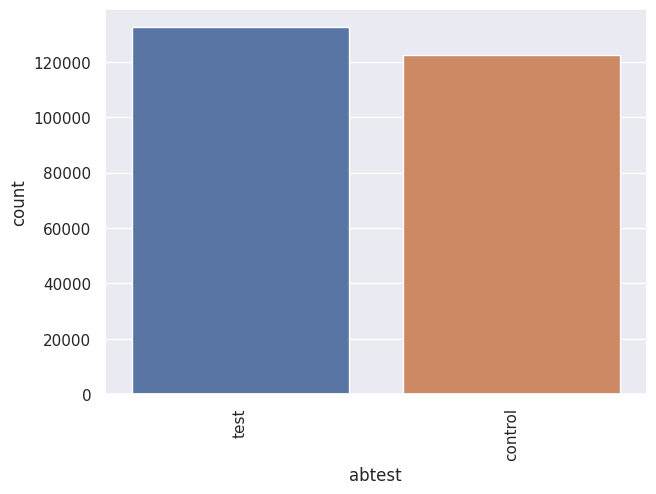

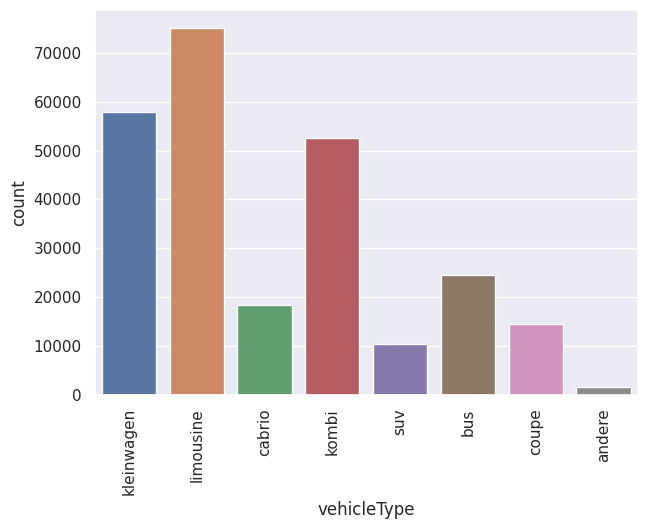

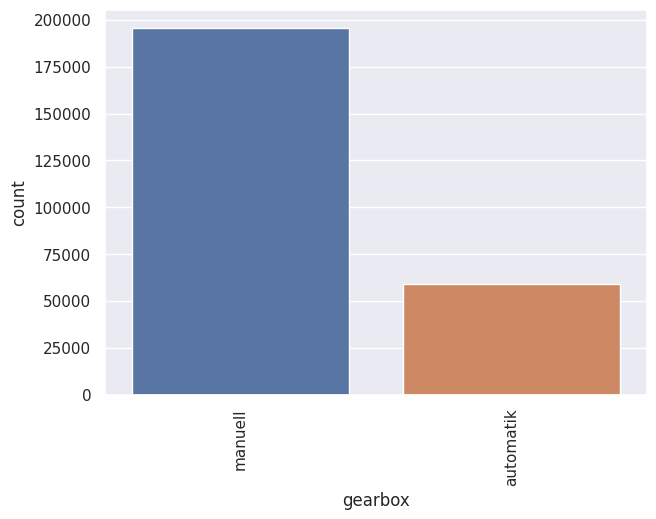

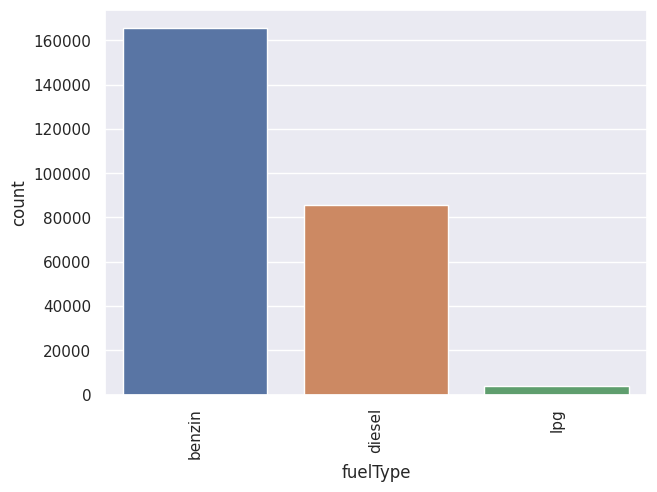

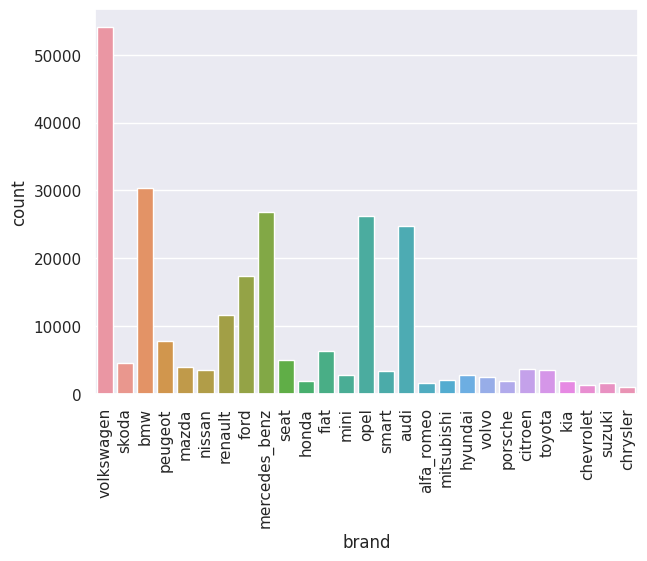

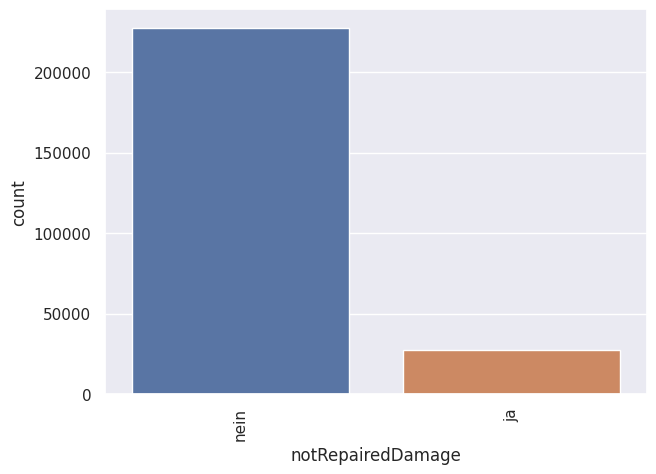

In [31]:
for column in categorical_columns:
    plt.figure(figsize = (7, 5))
    sns.countplot(data = df, x = column)
    plt.xticks(rotation = 90)
    plt.show()

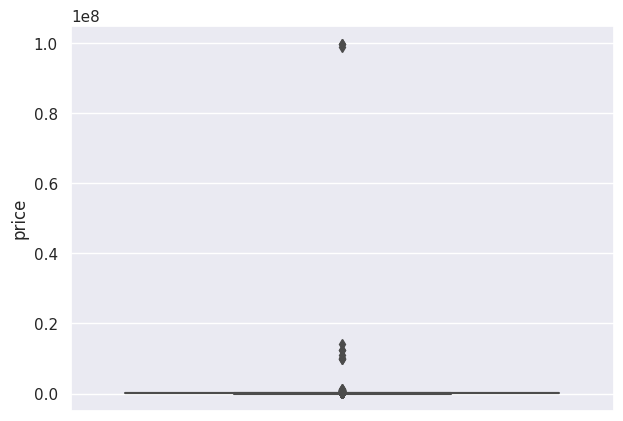

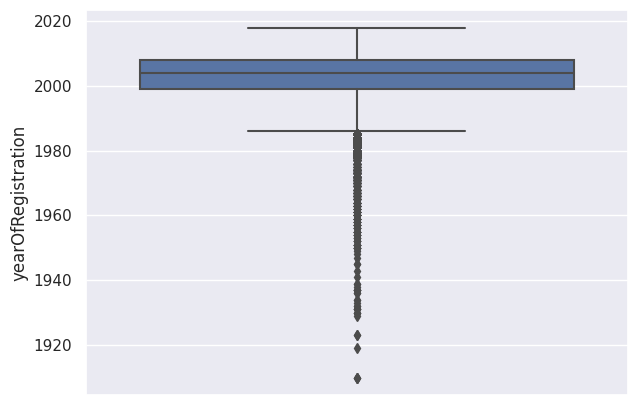

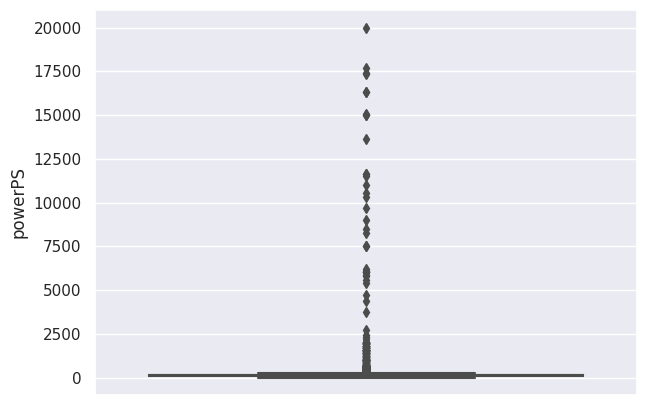

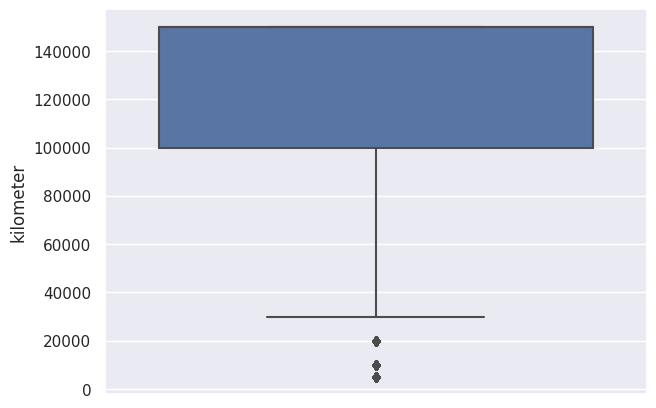

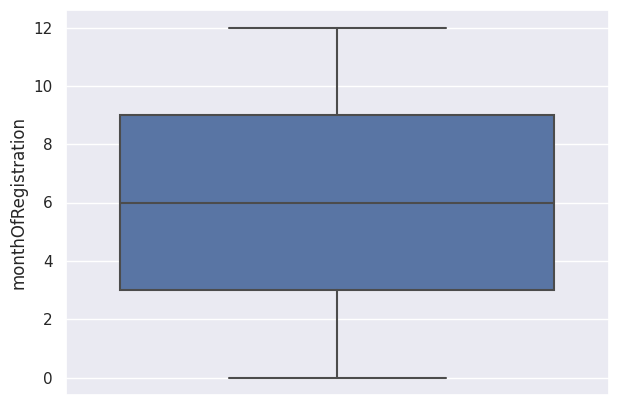

In [32]:
for column in numerical_columns:
    plt.figure(figsize = (7, 5))
    sns.boxplot(data = df, y = column)
    plt.show()

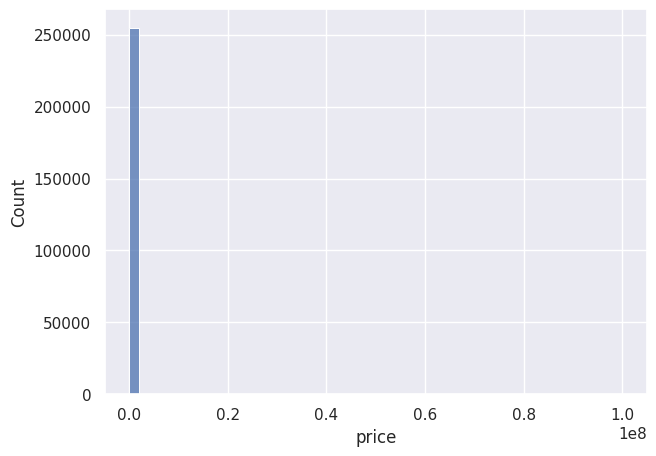

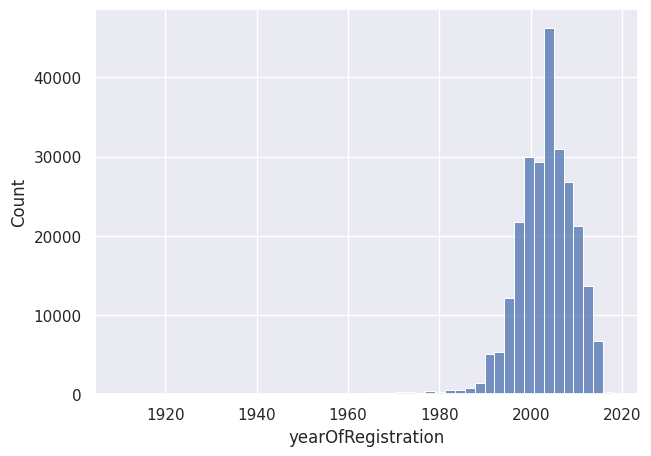

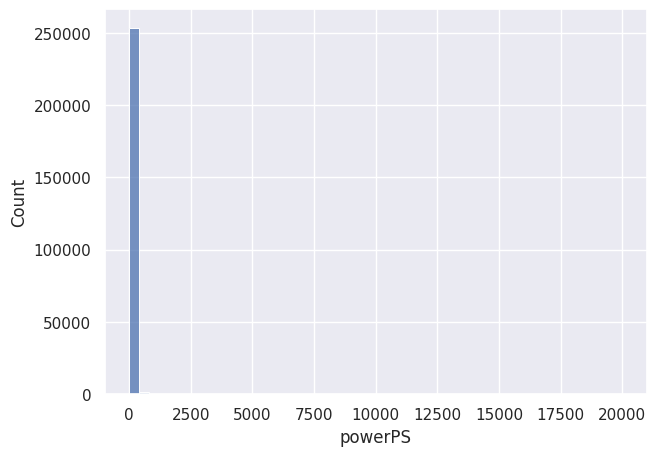

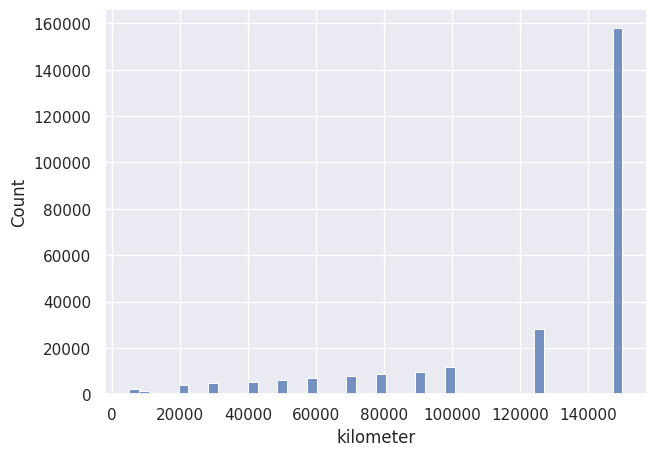

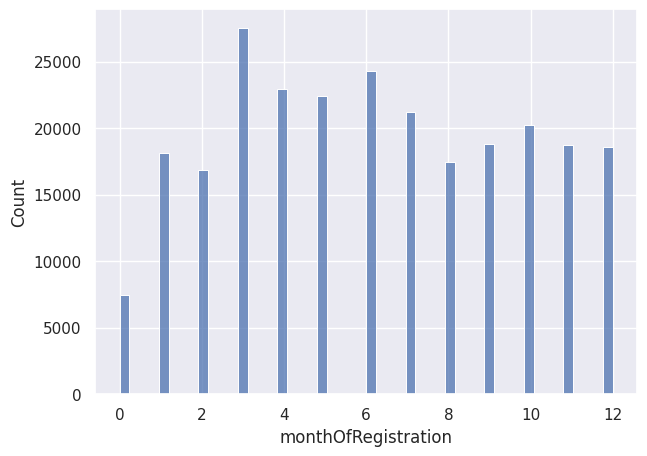

In [33]:
for column in numerical_columns:
    plt.figure(figsize = (7, 5))
    sns.histplot(data = df, x = column, bins = 50)
    plt.show()

In [34]:
df.shape

(254953, 12)

In [35]:
q1_1 = df['price'].quantile(0.99)
q1_2 = df['price'].quantile(0.01)
df = df[df['price'] < q1_1]
df = df[df['price'] > q1_2]

In [36]:
df.shape

(249089, 12)

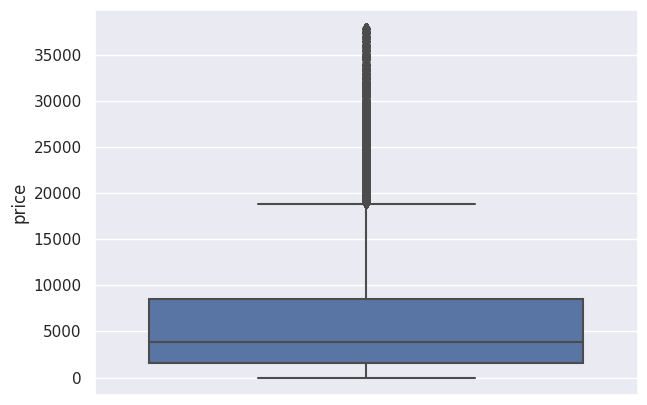

In [37]:
plt.figure(figsize = (7, 5))
sns.boxplot(data = df, y = 'price')
plt.show()

In [38]:
df[df['price'] > 18500].shape

(15360, 12)

In [39]:
df = df[df['price'] < 18500]

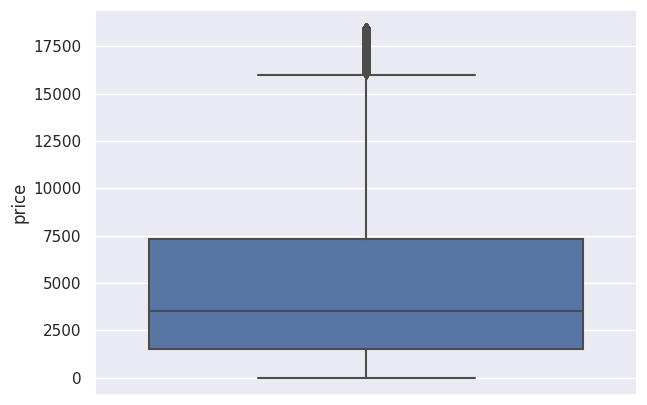

In [40]:
plt.figure(figsize = (7, 5))
sns.boxplot(data = df, y = 'price')
plt.show()

In [41]:
df[df['price'] > 15500].shape

(7844, 12)

In [42]:
df = df[df['price'] < 15500]

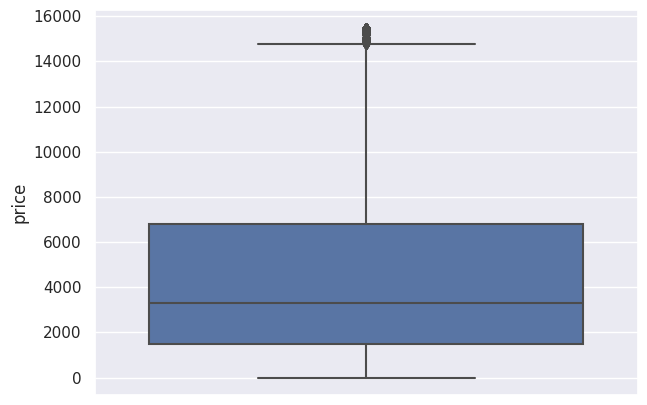

In [43]:
plt.figure(figsize = (7, 5))
sns.boxplot(data = df, y = 'price')
plt.show()

In [44]:
df[df['price'] > 14500].shape

(3149, 12)

In [45]:
df = df[df['price'] < 14500]

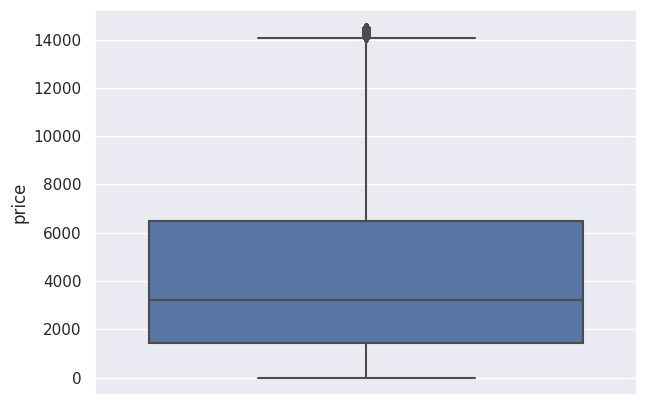

In [46]:
plt.figure(figsize = (7, 5))
sns.boxplot(data = df, y = 'price')
plt.show()

In [47]:
df[df['price'] > 14000].shape

(819, 12)

In [48]:
df = df[df['price'] < 14000]

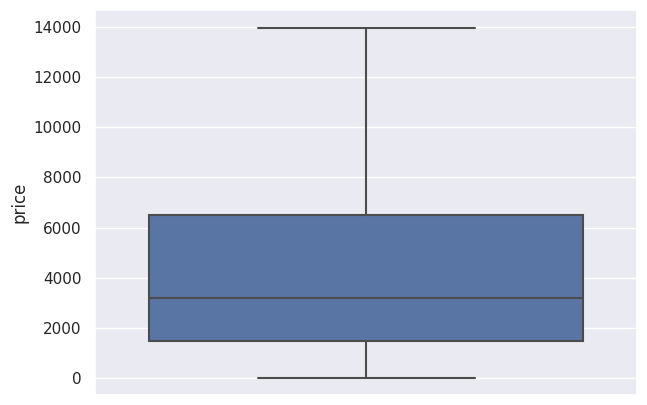

In [49]:
plt.figure(figsize = (7, 5))
sns.boxplot(data = df, y = 'price')
plt.show()

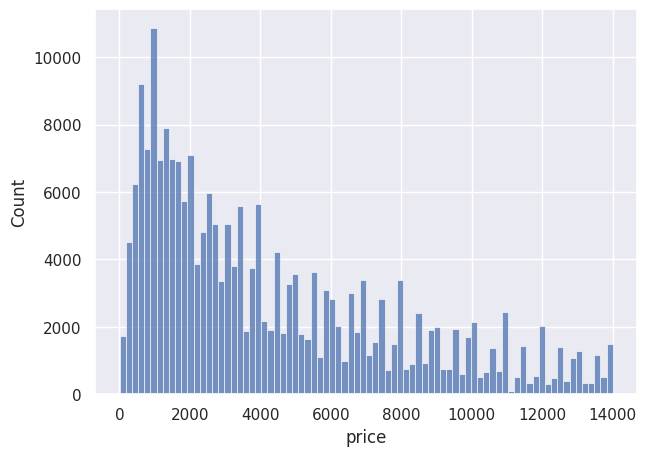

In [50]:
plt.figure(figsize = (7, 5))
sns.histplot(data = df, x = 'price', bins = 80)
plt.show()

In [51]:
df[df['yearOfRegistration'] < 1985].shape

(2046, 12)

In [52]:
df = df[df['yearOfRegistration'] > 1985]

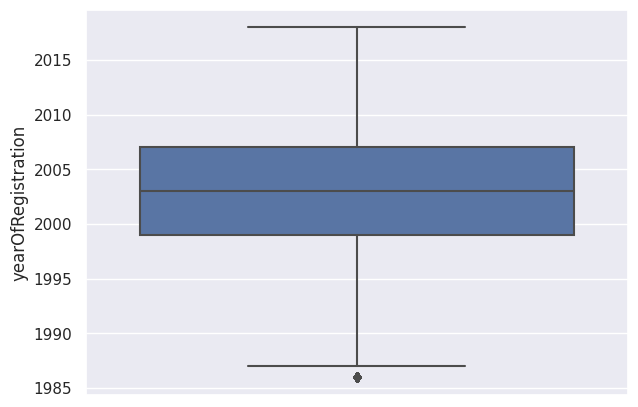

In [53]:
plt.figure(figsize = (7, 5))
sns.boxplot(data = df, y = 'yearOfRegistration')
plt.show()

In [54]:
df[df['yearOfRegistration'] < 1987].shape

(299, 12)

In [55]:
df = df[df['yearOfRegistration'] > 1987]

In [56]:
df.shape

(216796, 12)

In [57]:
q2_1 = df['powerPS'].quantile(0.99)
q2_2 = df['powerPS'].quantile(0.01)
df = df[df['powerPS'] < q2_1]
df = df[df['powerPS'] > q2_2]

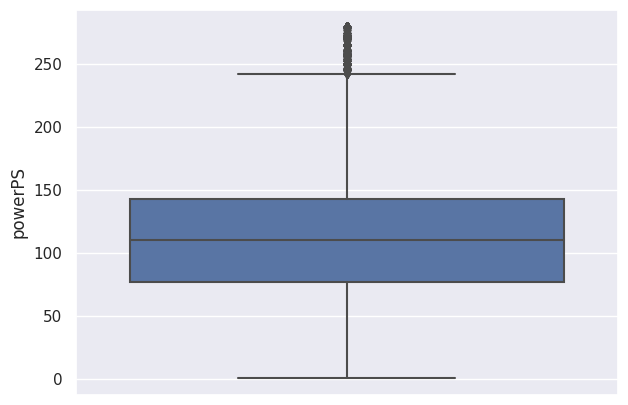

In [58]:
plt.figure(figsize = (7, 5))
sns.boxplot(data = df, y = 'powerPS')
plt.show()

In [59]:
df[df['powerPS'] > 240].shape

(2010, 12)

In [60]:
df = df[df['powerPS'] < 240]

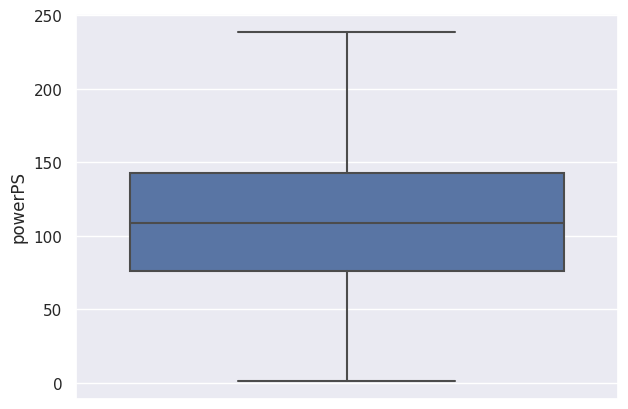

In [61]:
plt.figure(figsize = (7, 5))
sns.boxplot(data = df, y = 'powerPS')
plt.show()

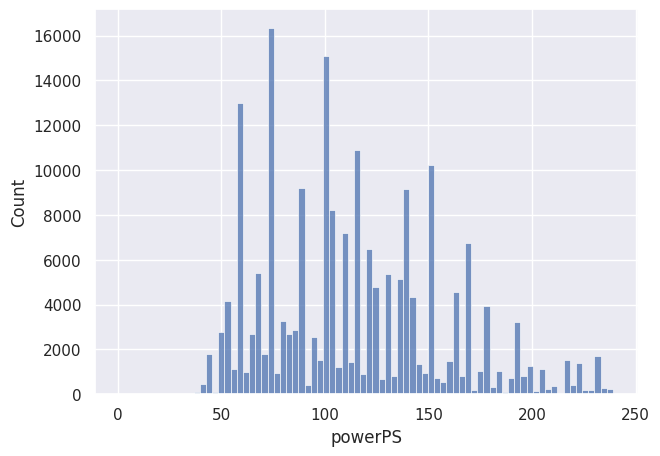

In [62]:
plt.figure(figsize = (7, 5))
sns.histplot(data = df, x = 'powerPS', bins = 80)
plt.show()

In [63]:
df[df['powerPS'] < 40].shape

(235, 12)

In [64]:
df = df[df['powerPS'] > 40]

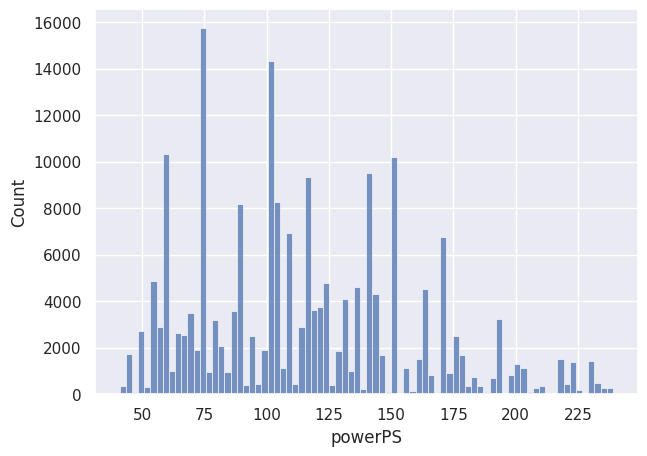

In [65]:
plt.figure(figsize = (7, 5))
sns.histplot(data = df, x = 'powerPS', bins = 80)
plt.show()

In [66]:
df[df['kilometer'] < 30000].shape

(3225, 12)

In [67]:
df = df[df['kilometer'] > 30000]

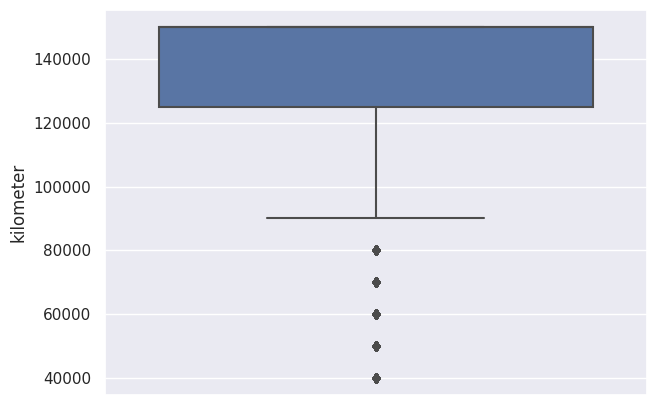

In [68]:
plt.figure(figsize = (7, 5))
sns.boxplot(data = df, y = 'kilometer')
plt.show()

In [69]:
df[df['kilometer'] < 90000].shape

(22085, 12)

In [70]:
df = df[df['kilometer'] > 90000]

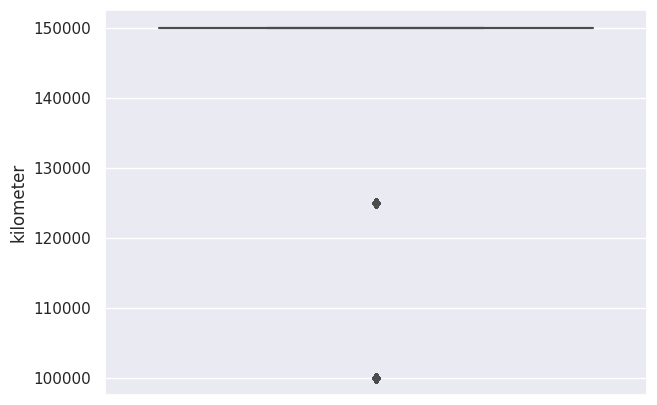

In [71]:
plt.figure(figsize = (7, 5))
sns.boxplot(data = df, y = 'kilometer')
plt.show()

In [72]:
df.shape

(169030, 12)

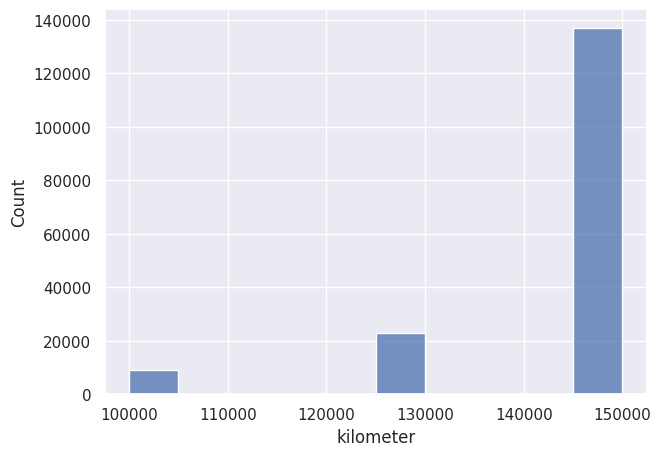

In [73]:
plt.figure(figsize = (7, 5))
sns.histplot(data = df, x = 'kilometer', bins = 10)
plt.show()

In [74]:
df.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated
3,1500,test,kleinwagen,2001,manuell,75,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00
5,650,test,limousine,1995,manuell,102,150000,10,benzin,bmw,ja,2016-04-04 00:00:00
6,2200,test,cabrio,2004,manuell,109,150000,8,benzin,peugeot,nein,2016-04-01 00:00:00
10,2000,control,limousine,2004,manuell,105,150000,12,benzin,mazda,nein,2016-03-26 00:00:00
11,2799,control,kombi,2005,manuell,140,150000,12,diesel,volkswagen,ja,2016-04-07 00:00:00


In [75]:
df.reset_index(drop = True, inplace = True)

In [76]:
df.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated
0,1500,test,kleinwagen,2001,manuell,75,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00
1,650,test,limousine,1995,manuell,102,150000,10,benzin,bmw,ja,2016-04-04 00:00:00
2,2200,test,cabrio,2004,manuell,109,150000,8,benzin,peugeot,nein,2016-04-01 00:00:00
3,2000,control,limousine,2004,manuell,105,150000,12,benzin,mazda,nein,2016-03-26 00:00:00
4,2799,control,kombi,2005,manuell,140,150000,12,diesel,volkswagen,ja,2016-04-07 00:00:00


In [77]:
def year(text):
    return text.split('-')[0]

In [78]:
df['year_created'] = df['dateCreated'].apply(year)

In [79]:
df.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,year_created
0,1500,test,kleinwagen,2001,manuell,75,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,2016
1,650,test,limousine,1995,manuell,102,150000,10,benzin,bmw,ja,2016-04-04 00:00:00,2016
2,2200,test,cabrio,2004,manuell,109,150000,8,benzin,peugeot,nein,2016-04-01 00:00:00,2016
3,2000,control,limousine,2004,manuell,105,150000,12,benzin,mazda,nein,2016-03-26 00:00:00,2016
4,2799,control,kombi,2005,manuell,140,150000,12,diesel,volkswagen,ja,2016-04-07 00:00:00,2016


In [80]:
def month(text):
    return text.split('-')[1]

In [81]:
df['month_created'] = df['dateCreated'].apply(month)

In [82]:
df.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,year_created,month_created
0,1500,test,kleinwagen,2001,manuell,75,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,2016,03
1,650,test,limousine,1995,manuell,102,150000,10,benzin,bmw,ja,2016-04-04 00:00:00,2016,04
2,2200,test,cabrio,2004,manuell,109,150000,8,benzin,peugeot,nein,2016-04-01 00:00:00,2016,04
3,2000,control,limousine,2004,manuell,105,150000,12,benzin,mazda,nein,2016-03-26 00:00:00,2016,03
4,2799,control,kombi,2005,manuell,140,150000,12,diesel,volkswagen,ja,2016-04-07 00:00:00,2016,04


In [83]:
df['month_created'].dtype

dtype('O')

In [84]:
df['year_created'] = pd.to_numeric(df['year_created'])

In [85]:
df['month_created'] = pd.to_numeric(df['month_created'])

In [86]:
df.shape

(169030, 14)

In [87]:
df[df['year_created'] > 2016]

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,year_created,month_created


In [88]:
df[df['year_created'] < 2016]

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,year_created,month_created
1906,6000,test,bus,1995,automatik,200,150000,0,benzin,chevrolet,nein,2015-03-20 00:00:00,2015,3
4725,3490,test,limousine,2006,manuell,88,150000,3,benzin,renault,nein,2015-11-02 00:00:00,2015,11
14131,6950,test,limousine,2004,automatik,150,100000,1,benzin,audi,nein,2015-12-06 00:00:00,2015,12
28643,5999,control,limousine,1997,automatik,197,150000,9,benzin,mercedes_benz,nein,2015-11-17 00:00:00,2015,11
36079,600,test,kleinwagen,2005,manuell,54,150000,1,benzin,volkswagen,ja,2015-09-04 00:00:00,2015,9
105270,600,test,kleinwagen,2005,manuell,54,150000,1,benzin,volkswagen,ja,2015-09-04 00:00:00,2015,9
130774,9999,test,kombi,2006,automatik,140,150000,5,diesel,audi,nein,2015-12-17 00:00:00,2015,12


In [89]:
df_tv = df[df['month_created'] > 3][df['year_created'] == 2016]
df_train = df[df['month_created'] <= 3]

In [90]:
df_train.shape

(141667, 14)

In [91]:
df_tv.shape

(27357, 14)

In [92]:
df_tv.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,year_created,month_created
1,650,test,limousine,1995,manuell,102,150000,10,benzin,bmw,ja,2016-04-04 00:00:00,2016,4
2,2200,test,cabrio,2004,manuell,109,150000,8,benzin,peugeot,nein,2016-04-01 00:00:00,2016,4
4,2799,control,kombi,2005,manuell,140,150000,12,diesel,volkswagen,ja,2016-04-07 00:00:00,2016,4
7,1850,test,bus,2004,manuell,102,150000,1,benzin,mercedes_benz,nein,2016-04-01 00:00:00,2016,4
8,10400,control,coupe,2009,manuell,160,100000,4,benzin,volkswagen,nein,2016-04-01 00:00:00,2016,4


In [93]:
def day(text):
    return text.split('00:00:00')[0].split('-')[2].strip()

In [94]:
df_tv['day'] = df_tv['dateCreated'].apply(day)

In [95]:
df_tv.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,year_created,month_created,day
1,650,test,limousine,1995,manuell,102,150000,10,benzin,bmw,ja,2016-04-04 00:00:00,2016,4,04
2,2200,test,cabrio,2004,manuell,109,150000,8,benzin,peugeot,nein,2016-04-01 00:00:00,2016,4,01
4,2799,control,kombi,2005,manuell,140,150000,12,diesel,volkswagen,ja,2016-04-07 00:00:00,2016,4,07
7,1850,test,bus,2004,manuell,102,150000,1,benzin,mercedes_benz,nein,2016-04-01 00:00:00,2016,4,01
8,10400,control,coupe,2009,manuell,160,100000,4,benzin,volkswagen,nein,2016-04-01 00:00:00,2016,4,01


In [96]:
df_tv['day'] = pd.to_numeric(df_tv['day'])

In [97]:
df_tv[df_tv['day'] > 3].shape

(9171, 15)

In [98]:
df_valid = df_tv[df_tv['day'] > 3]

In [99]:
df_test = df_tv[df_tv['day'] <= 3]

In [100]:
df_valid.shape

(9171, 15)

In [101]:
df_test.shape

(18186, 15)

In [102]:
df_train.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,year_created,month_created
0,1500,test,kleinwagen,2001,manuell,75,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,2016,3
3,2000,control,limousine,2004,manuell,105,150000,12,benzin,mazda,nein,2016-03-26 00:00:00,2016,3
5,1750,control,kleinwagen,2004,automatik,75,150000,2,benzin,renault,nein,2016-03-20 00:00:00,2016,3
6,7550,test,bus,2007,manuell,136,150000,6,diesel,ford,nein,2016-03-23 00:00:00,2016,3
9,3699,test,limousine,2002,automatik,231,150000,7,benzin,bmw,nein,2016-03-27 00:00:00,2016,3


In [103]:
df_train.drop(columns = ['dateCreated', 'year_created', 'month_created'], axis = 1, inplace = True)

In [104]:
df_valid.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,year_created,month_created,day
1,650,test,limousine,1995,manuell,102,150000,10,benzin,bmw,ja,2016-04-04 00:00:00,2016,4,4
4,2799,control,kombi,2005,manuell,140,150000,12,diesel,volkswagen,ja,2016-04-07 00:00:00,2016,4,7
21,13500,test,bus,2012,automatik,109,150000,7,diesel,mercedes_benz,nein,2016-04-04 00:00:00,2016,4,4
47,3500,control,coupe,1991,manuell,160,150000,5,benzin,volkswagen,nein,2016-04-04 00:00:00,2016,4,4
64,4200,control,kombi,2003,automatik,204,150000,1,diesel,bmw,nein,2016-04-05 00:00:00,2016,4,5


In [105]:
df_valid.drop(columns = ['dateCreated', 'year_created', 'month_created', 'day'], axis = 1, inplace = True)

In [106]:
df_test.drop(columns = ['dateCreated', 'year_created', 'month_created', 'day'], axis = 1, inplace = True)

In [107]:
print('The size of training set is:', df_train.shape[0])
print('The size of test set is:', df_test.shape[0])
print('The size of validation set is:', df_valid.shape[0])

The size of training set is: 141667
The size of test set is: 18186
The size of validation set is: 9171


In [108]:
X_train = df_train.drop(columns = ['price'], axis = 1)
y_train = df_train['price']

In [109]:
X_test = df_test.drop(columns = ['price'], axis = 1)
y_test = df_test['price']

In [110]:
X_valid = df_valid.drop(columns = ['price'], axis = 1)
y_valid = df_valid['price']

In [111]:
X_train.head()

,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,test,kleinwagen,2001,manuell,75,150000,6,benzin,volkswagen,nein
3,control,limousine,2004,manuell,105,150000,12,benzin,mazda,nein
5,control,kleinwagen,2004,automatik,75,150000,2,benzin,renault,nein
6,test,bus,2007,manuell,136,150000,6,diesel,ford,nein
9,test,limousine,2002,automatik,231,150000,7,benzin,bmw,nein


In [112]:
numerical_columns

['price', 'yearOfRegistration', 'powerPS', 'kilometer', 'monthOfRegistration']

In [113]:
categorical_columns

['abtest', 'vehicleType', 'gearbox', 'fuelType', 'brand', 'notRepairedDamage']

In [114]:
numerical_columns.remove('price')

In [115]:
ct = ColumnTransformer(transformers = [
    ('ohe', OneHotEncoder(drop = 'first', sparse_output = False, handle_unknown = 'ignore'), categorical_columns),
    ('scaler', StandardScaler(), numerical_columns)
], remainder = 'passthrough')

In [116]:
X_train_f = ct.fit_transform(X_train)

In [117]:
X_train_f[0]

array([ 1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  1.        , -0.22677942, -0.98628764,
        0.44929506, -0.05623321])

In [118]:
X_valid_f = ct.transform(X_valid)

In [119]:
X_valid_f[0]

array([ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -1.51739826, -0.36634931,
        0.44929506,  1.09431412])

In [120]:
model = Sequential()

In [121]:
model.add(Input(shape = (42,)))
model.add(Dense(512))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(1, activation = 'linear'))

In [122]:
model.compile(
    optimizer = 'adam',
    loss = 'mae',
    metrics = ['mae']
)

In [123]:
history = model.fit(X_train_f, y_train, validation_data = (X_valid_f, y_valid), epochs = 40, batch_size = 32)

Epoch 1/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 3457.3093 - mae: 3457.3093 - val_loss: 1676.6458 - val_mae: 1676.6458
Epoch 2/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1303.4303 - mae: 1303.4303 - val_loss: 937.1192 - val_mae: 937.1192
Epoch 3/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 993.1680 - mae: 993.1680 - val_loss: 898.7770 - val_mae: 898.7770
Epoch 4/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 990.3892 - mae: 990.3892 - val_loss: 950.4648 - val_mae: 950.4648
Epoch 5/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 979.6449 - mae: 979.6449 - val_loss: 892.0276 - val_mae: 892.0276
Epoch 6/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 971.5665 - mae: 971.5665 - val_loss: 902.3131 - val_mae: 902.3131
Epoch 7/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 966.1859 - mae: 966.1859 - val_loss: 892.0122 - val_mae: 892.0122
Epoch 8/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 966.0003 - mae: 966.0003 - v

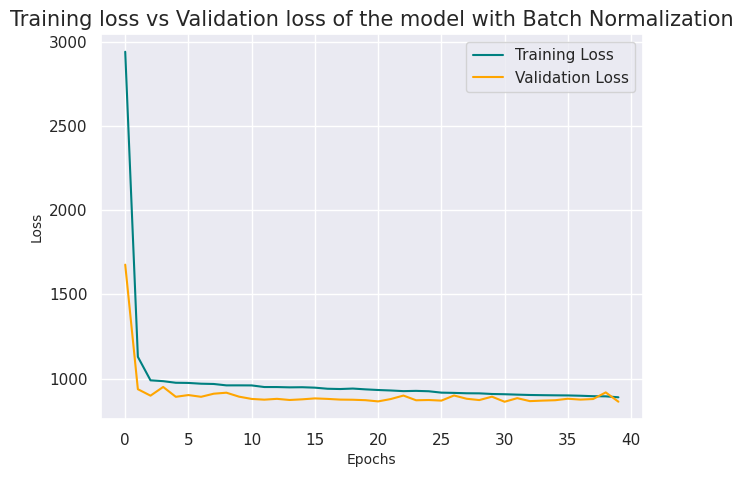

In [124]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training loss vs Validation loss of the model with Batch Normalization', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

In [125]:
model2 = Sequential()

In [126]:
model2.add(Input(shape = (42,)))
model2.add(Dense(512))
model2.add(LeakyReLU())
model2.add(Dense(512))
model2.add(LeakyReLU())
model2.add(Dense(256))
model2.add(LeakyReLU())
model2.add(Dense(256))
model2.add(LeakyReLU())
model2.add(Dense(128))
model2.add(LeakyReLU())
model2.add(Dense(64))
model2.add(LeakyReLU())
model2.add(Dense(1, activation = 'linear'))

In [127]:
model2.compile(
    optimizer = 'adam',
    loss = 'mae',
    metrics = ['mae']
)

In [128]:
history2 = model2.fit(X_train_f, y_train, validation_data = (X_valid_f, y_valid), epochs = 40, batch_size = 32)

Epoch 1/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 1062.5212 - mae: 1062.5212 - val_loss: 961.7415 - val_mae: 961.7415
Epoch 2/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 895.4797 - mae: 895.4797 - val_loss: 919.8829 - val_mae: 919.8829
Epoch 3/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 874.6296 - mae: 874.6296 - val_loss: 907.3414 - val_mae: 907.3414
Epoch 4/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 869.7560 - mae: 869.7560 - val_loss: 893.5016 - val_mae: 893.5016
Epoch 5/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 860.0472 - mae: 860.0472 - val_loss: 897.1150 - val_mae: 897.1150
Epoch 6/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 858.8149 - mae: 858.8149 - val_loss: 900.9189 - val_mae: 900.9189
Epoch 7/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 851.1298 - mae: 851.1298 - val_loss: 880.5661 - val_mae: 880.5661
Epoch 8/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 850.7183 - mae: 850.7183 - val_loss: 8

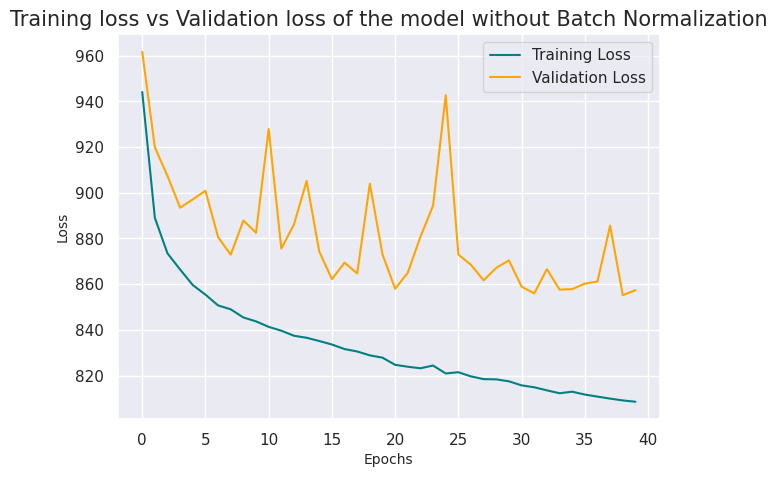

In [129]:
plt.figure(figsize = (7, 5))
plt.plot(history2.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history2.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training loss vs Validation loss of the model without Batch Normalization', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

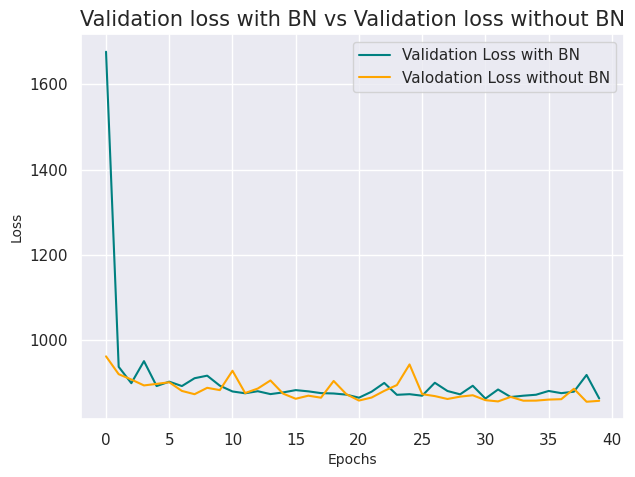

In [130]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['val_loss'], label = 'Validation Loss with BN', color = 'teal')
plt.plot(history2.history['val_loss'], label = 'Validation Loss without BN', color = 'orange')
plt.title('Validation loss with BN vs Validation loss without BN', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

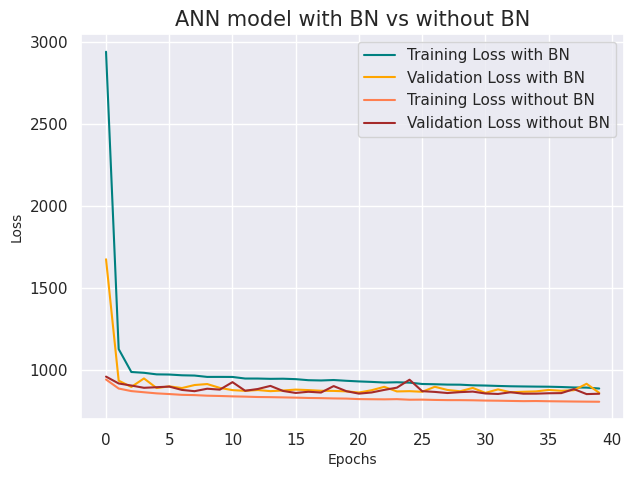

In [153]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['loss'], label = 'Training Loss with BN', color = 'teal')
plt.plot(history.history['val_loss'], label = 'Validation Loss with BN', color = 'orange')
plt.plot(history2.history['loss'], label = 'Training Loss without BN', color = 'coral')
plt.plot(history2.history['val_loss'], label = 'Validation Loss without BN', color = 'brown')
plt.title('ANN model with BN vs without BN', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

In [145]:
mean = 0
std_dev = 0.1
train_noise = np.random.normal(mean, std_dev, X_train_f.shape)
X_train_noisy = X_train_f + train_noise

In [146]:
X_train_f[0]

array([ 1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  1.        , -0.22677942, -0.98628764,
        0.44929506, -0.05623321])

In [147]:
X_train_noisy[0]

array([ 0.97013545, -0.05506995,  0.09477636,  0.03629611,  0.94686667,
       -0.10518488, -0.00824597,  0.09526716,  1.05056157,  0.14236762,
        0.12021566,  0.05327613, -0.06783031, -0.17656614, -0.16234163,
       -0.03863589,  0.21478849,  0.22676872,  0.13939497, -0.13173184,
        0.04714496, -0.02711781,  0.00666021, -0.07834945, -0.2093294 ,
        0.13939879, -0.07910493, -0.03336998, -0.00401605,  0.0981028 ,
        0.06168319, -0.01969989, -0.1860991 ,  0.04962355, -0.05222044,
        1.03259383,  0.1281539 ,  0.97207091, -0.14477739, -0.96020349,
        0.44751789, -0.10097493])

In [148]:
valid_noise = np.random.normal(mean, std_dev, X_valid_f.shape)
X_valid_noisy = X_valid_f + valid_noise

In [149]:
model3 = Sequential()

In [150]:
model3.add(Input(shape = (42,)))
model3.add(Dense(512))
model3.add(BatchNormalization())
model3.add(LeakyReLU())
model3.add(Dense(512))
model3.add(BatchNormalization())
model3.add(LeakyReLU())
model3.add(Dense(256))
model3.add(BatchNormalization())
model3.add(LeakyReLU())
model3.add(Dense(256))
model3.add(BatchNormalization())
model3.add(LeakyReLU())
model3.add(Dense(128))
model3.add(BatchNormalization())
model3.add(LeakyReLU())
model3.add(Dense(64))
model3.add(BatchNormalization())
model3.add(LeakyReLU())
model3.add(Dense(1, activation = 'linear'))

In [151]:
model3.compile(
    optimizer = 'adam',
    loss = 'mae',
    metrics = ['mae']
)

In [152]:
history3 = model3.fit(X_train_noisy, y_train, validation_data = (X_valid_noisy, y_valid), epochs = 40, batch_size = 32)

Epoch 1/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 3457.7141 - mae: 3457.7141 - val_loss: 1653.4689 - val_mae: 1653.4689
Epoch 2/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 1337.4103 - mae: 1337.4103 - val_loss: 970.0610 - val_mae: 970.0610
Epoch 3/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1036.4800 - mae: 1036.4800 - val_loss: 947.6716 - val_mae: 947.6716
Epoch 4/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 1031.0338 - mae: 1031.0338 - val_loss: 1017.2100 - val_mae: 1017.2100
Epoch 5/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 1023.2136 - mae: 1023.2136 - val_loss: 955.9165 - val_mae: 955.9165
Epoch 6/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1015.7324 - mae: 1015.7324 - val_loss: 975.2208 - val_mae: 975.2208
Epoch 7/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 1009.5673 - mae: 1009.5673 - val_loss: 943.2723 - val_mae: 943.2723
Epoch 8/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1007.9822 - mae:

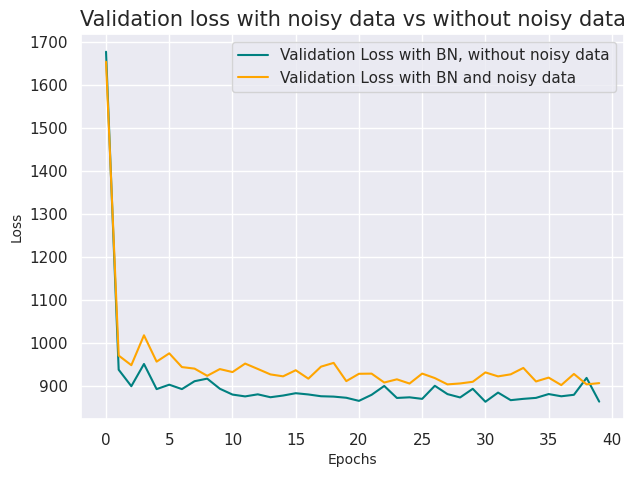

In [155]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['val_loss'], label = 'Validation Loss with BN, without noisy data', color = 'teal')
plt.plot(history3.history['val_loss'], label = 'Validation Loss with BN and noisy data', color = 'orange')
plt.title('Validation loss with noisy data vs without noisy data', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

In [166]:
model4 = Sequential()

In [167]:
model4.add(Input(shape = (42,)))
model4.add(Dense(512, kernel_regularizer = regularizers.L1(0.01)))
model4.add(BatchNormalization())
model4.add(LeakyReLU())
model4.add(Dense(512, kernel_regularizer = regularizers.L1(0.01)))
model4.add(BatchNormalization())
model4.add(LeakyReLU())
model4.add(Dense(256, kernel_regularizer = regularizers.L1(0.01)))
model4.add(BatchNormalization())
model4.add(LeakyReLU())
model4.add(Dense(256, kernel_regularizer = regularizers.L1(0.01)))
model4.add(BatchNormalization())
model4.add(LeakyReLU())
model4.add(Dense(128, kernel_regularizer = regularizers.L1(0.01)))
model4.add(BatchNormalization())
model4.add(LeakyReLU())
model4.add(Dense(64, kernel_regularizer = regularizers.L1(0.01)))
model4.add(BatchNormalization())
model4.add(LeakyReLU())
model4.add(Dense(1, activation = 'linear'))

In [168]:
model4.compile(
    optimizer = 'adam',
    loss = 'mae',
    metrics = ['mae']
)

In [169]:
history4 = model4.fit(X_train_f, y_train, validation_data = (X_valid_f, y_valid), epochs = 40, batch_size = 32)

Epoch 1/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 3488.9739 - mae: 3465.8096 - val_loss: 1729.2313 - val_mae: 1701.1149
Epoch 2/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 1454.8376 - mae: 1427.7214 - val_loss: 954.0130 - val_mae: 932.4263
Epoch 3/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 1034.5497 - mae: 1013.3687 - val_loss: 915.2219 - val_mae: 898.6553
Epoch 4/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1003.5578 - mae: 988.1971 - val_loss: 908.4535 - val_mae: 894.1091
Epoch 5/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1002.2454 - mae: 988.5729 - val_loss: 907.5065 - val_mae: 894.6635
Epoch 6/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 991.2654 - mae: 978.5001 - val_loss: 901.8255 - val_mae: 889.2157
Epoch 7/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 986.7507 - mae: 974.2946 - val_loss: 903.3203 - val_mae: 891.0830
Epoch 8/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 980.7725 - mae: 968.5570

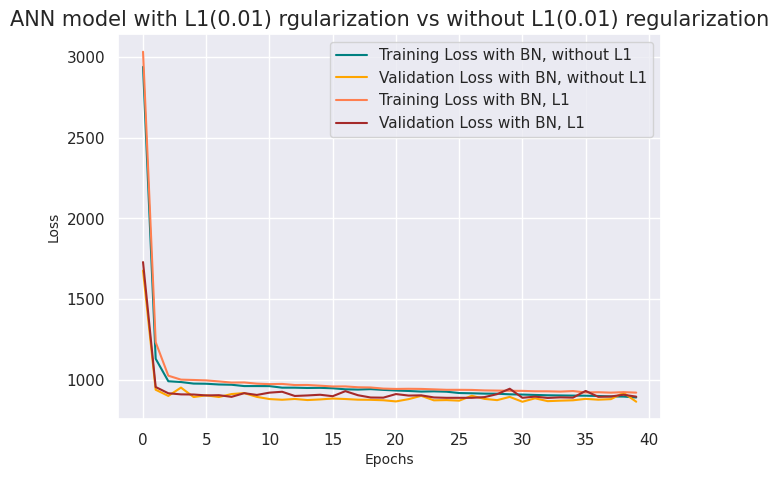

In [173]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['loss'], label = 'Training Loss with BN, without L1', color = 'teal')
plt.plot(history.history['val_loss'], label = 'Validation Loss with BN, without L1', color = 'orange')
plt.plot(history4.history['loss'], label = 'Training Loss with BN, L1', color = 'coral')
plt.plot(history4.history['val_loss'], label = 'Validation Loss with BN, L1', color = 'brown')
plt.title('ANN model with L1(0.01) rgularization vs without L1(0.01) regularization', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

In [174]:
model5 = Sequential()

In [175]:
model5.add(Input(shape = (42,)))
model5.add(Dense(512, kernel_regularizer = regularizers.L1(0.1)))
model5.add(BatchNormalization())
model5.add(LeakyReLU())
model5.add(Dense(512, kernel_regularizer = regularizers.L1(0.1)))
model5.add(BatchNormalization())
model5.add(LeakyReLU())
model5.add(Dense(256, kernel_regularizer = regularizers.L1(0.1)))
model5.add(BatchNormalization())
model5.add(LeakyReLU())
model5.add(Dense(256, kernel_regularizer = regularizers.L1(0.1)))
model5.add(BatchNormalization())
model5.add(LeakyReLU())
model5.add(Dense(128, kernel_regularizer = regularizers.L1(0.1)))
model5.add(BatchNormalization())
model5.add(LeakyReLU())
model5.add(Dense(64, kernel_regularizer = regularizers.L1(0.1)))
model5.add(BatchNormalization())
model5.add(LeakyReLU())
model5.add(Dense(1, activation = 'linear'))

In [176]:
model5.compile(
    optimizer = 'adam',
    loss = 'mae',
    metrics = ['mae']
)

In [177]:
history5 = model5.fit(X_train_f, y_train, validation_data = (X_valid_f, y_valid), epochs = 40, batch_size = 32)

Epoch 1/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 3616.2173 - mae: 3490.1963 - val_loss: 2269.2515 - val_mae: 2205.6650
Epoch 2/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1603.7296 - mae: 1531.3273 - val_loss: 1205.7933 - val_mae: 1144.6261
Epoch 3/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 1058.5979 - mae: 1012.9240 - val_loss: 971.2358 - val_mae: 931.9106
Epoch 4/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1035.1658 - mae: 997.8057 - val_loss: 958.6060 - val_mae: 925.8062
Epoch 5/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 1022.6895 - mae: 990.4366 - val_loss: 956.4191 - val_mae: 927.5128
Epoch 6/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 1006.4315 - mae: 977.7558 - val_loss: 929.0871 - val_mae: 902.0591
Epoch 7/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 1014.2716 - mae: 987.3591 - val_loss: 921.2393 - val_mae: 893.7313
Epoch 8/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1007.9746 - mae: 981

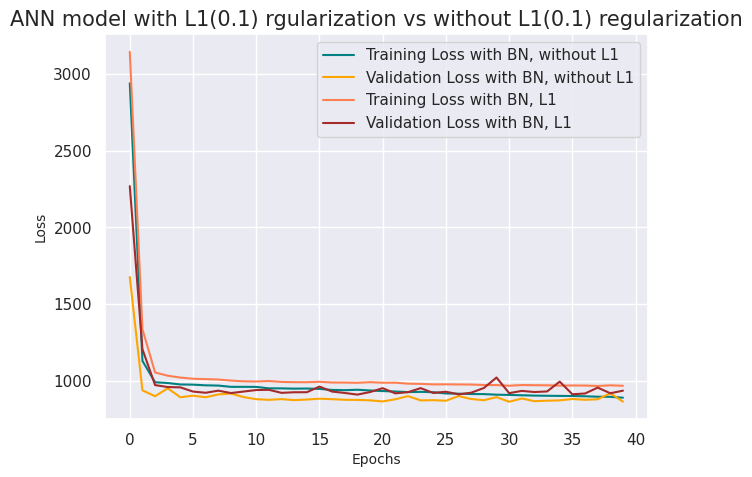

In [178]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['loss'], label = 'Training Loss with BN, without L1', color = 'teal')
plt.plot(history.history['val_loss'], label = 'Validation Loss with BN, without L1', color = 'orange')
plt.plot(history5.history['loss'], label = 'Training Loss with BN, L1', color = 'coral')
plt.plot(history5.history['val_loss'], label = 'Validation Loss with BN, L1', color = 'brown')
plt.title('ANN model with L1(0.1) rgularization vs without L1(0.1) regularization', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

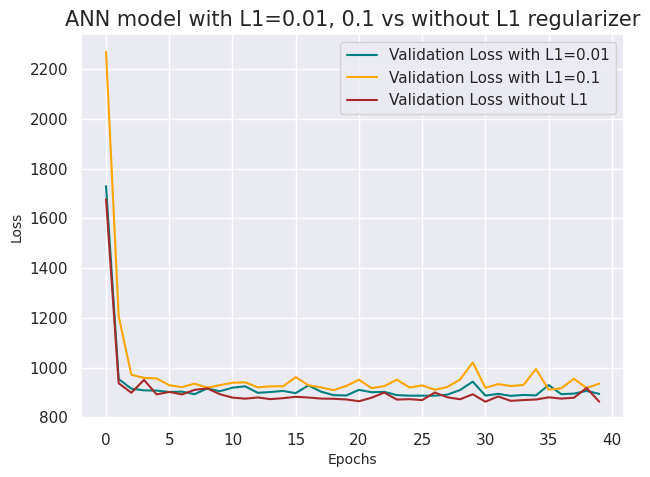

In [179]:
plt.figure(figsize = (7, 5))
plt.plot(history4.history['val_loss'], label = 'Validation Loss with L1=0.01', color = 'teal')
plt.plot(history5.history['val_loss'], label = 'Validation Loss with L1=0.1', color = 'orange')
plt.plot(history.history['val_loss'], label = 'Validation Loss without L1', color = 'brown')
plt.title('ANN model with L1=0.01, 0.1 vs without L1 regularizer', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

In [184]:
model6 = Sequential()

In [185]:
model6.add(Input(shape = (42,)))
model6.add(Dense(512, kernel_regularizer = regularizers.L2(0.01)))
model6.add(BatchNormalization())
model6.add(LeakyReLU())
model6.add(Dense(512, kernel_regularizer = regularizers.L2(0.01)))
model6.add(BatchNormalization())
model6.add(LeakyReLU())
model6.add(Dense(256, kernel_regularizer = regularizers.L2(0.01)))
model6.add(BatchNormalization())
model6.add(LeakyReLU())
model6.add(Dense(256, kernel_regularizer = regularizers.L2(0.01)))
model6.add(BatchNormalization())
model6.add(LeakyReLU())
model6.add(Dense(128, kernel_regularizer = regularizers.L2(0.01)))
model6.add(BatchNormalization())
model6.add(LeakyReLU())
model6.add(Dense(64, kernel_regularizer = regularizers.L2(0.01)))
model6.add(BatchNormalization())
model6.add(LeakyReLU())
model6.add(Dense(1, activation = 'linear'))

In [186]:
model6.compile(
    optimizer = 'adam',
    loss = 'mae',
    metrics = ['mae']
)

In [187]:
history6 = model6.fit(X_train_f, y_train, validation_data = (X_valid_f, y_valid), epochs = 40, batch_size = 32)

Epoch 1/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 3464.2385 - mae: 3461.7434 - val_loss: 1728.5522 - val_mae: 1723.1508
Epoch 2/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 1332.1685 - mae: 1325.0020 - val_loss: 966.5345 - val_mae: 956.8252
Epoch 3/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 1009.7216 - mae: 999.7354 - val_loss: 934.6299 - val_mae: 924.2267
Epoch 4/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 999.7196 - mae: 989.4285 - val_loss: 933.5468 - val_mae: 923.3215
Epoch 5/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 996.5949 - mae: 986.3712 - val_loss: 903.7628 - val_mae: 893.6687
Epoch 6/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 990.8644 - mae: 980.4641 - val_loss: 902.7312 - val_mae: 892.6619
Epoch 7/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 981.7853 - mae: 971.7847 - val_loss: 899.7149 - val_mae: 890.0591
Epoch 8/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 981.8003 - mae: 972.1158 - 

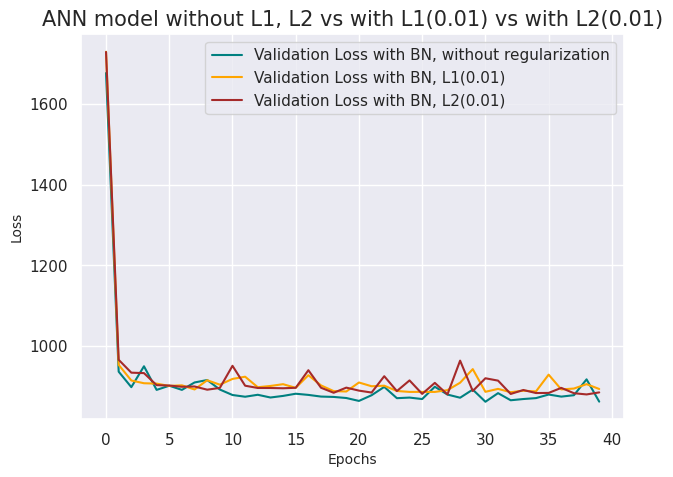

In [188]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['val_loss'], label = 'Validation Loss with BN, without regularization', color = 'teal')
plt.plot(history4.history['val_loss'], label = 'Validation Loss with BN, L1(0.01)', color = 'orange')
plt.plot(history6.history['val_loss'], label = 'Validation Loss with BN, L2(0.01)', color = 'brown')
plt.title('ANN model without L1, L2 vs with L1(0.01) vs with L2(0.01)', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

In [189]:
model7 = Sequential()

In [190]:
model7.add(Input(shape = (42,)))
model7.add(Dense(512))
model7.add(BatchNormalization())
model7.add(LeakyReLU())
model7.add(Dropout(0.2))
model7.add(Dense(512))
model7.add(BatchNormalization())
model7.add(LeakyReLU())
model7.add(Dropout(0.2))
model7.add(Dense(256))
model7.add(BatchNormalization())
model7.add(LeakyReLU())
model7.add(Dropout(0.2))
model7.add(Dense(256))
model7.add(BatchNormalization())
model7.add(LeakyReLU())
model7.add(Dropout(0.2))
model7.add(Dense(128))
model7.add(BatchNormalization())
model7.add(LeakyReLU())
model7.add(Dropout(0.2))
model7.add(Dense(64))
model7.add(BatchNormalization())
model7.add(LeakyReLU())
model7.add(Dropout(0.2))
model7.add(Dense(1, activation = 'linear'))

In [191]:
model7.compile(
    optimizer = 'adam',
    loss = 'mae',
    metrics = ['mae']
)

In [192]:
history7 = model7.fit(X_train_f, y_train, validation_data = (X_valid_f, y_valid), epochs = 40, batch_size = 32)

Epoch 1/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 3433.7754 - mae: 3433.7754 - val_loss: 1538.7333 - val_mae: 1538.7333
Epoch 2/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 1286.3464 - mae: 1286.3464 - val_loss: 913.5827 - val_mae: 913.5827
Epoch 3/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 1052.8108 - mae: 1052.8108 - val_loss: 902.8670 - val_mae: 902.8670
Epoch 4/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 1030.6322 - mae: 1030.6322 - val_loss: 900.4177 - val_mae: 900.4177
Epoch 5/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 1017.6094 - mae: 1017.6094 - val_loss: 912.6561 - val_mae: 912.6561
Epoch 6/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 1025.0660 - mae: 1025.0660 - val_loss: 892.4639 - val_mae: 892.4639
Epoch 7/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 1006.8469 - mae: 1006.8469 - val_loss: 900.3736 - val_mae: 900.3736
Epoch 8/40
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 1014.0197 - mae: 1

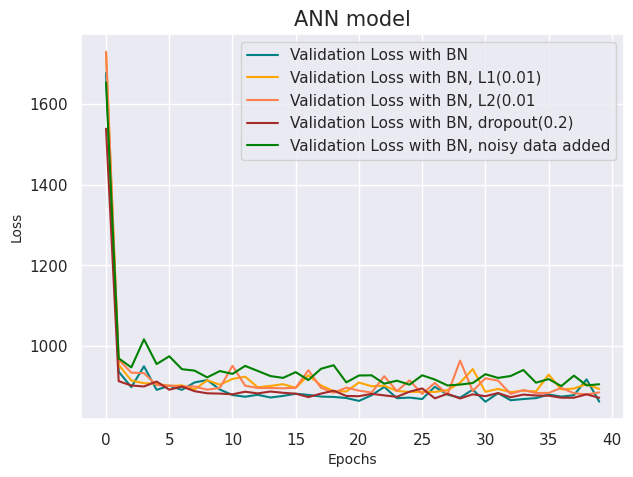

In [193]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['val_loss'], label = 'Validation Loss with BN', color = 'teal')
plt.plot(history4.history['val_loss'], label = 'Validation Loss with BN, L1(0.01)', color = 'orange')
plt.plot(history6.history['val_loss'], label = 'Validation Loss with BN, L2(0.01', color = 'coral')
plt.plot(history7.history['val_loss'], label = 'Validation Loss with BN, dropout(0.2)', color = 'brown')
plt.plot(history3.history['val_loss'], label = 'Validation Loss with BN, noisy data added', color = 'green')
plt.title('ANN model', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

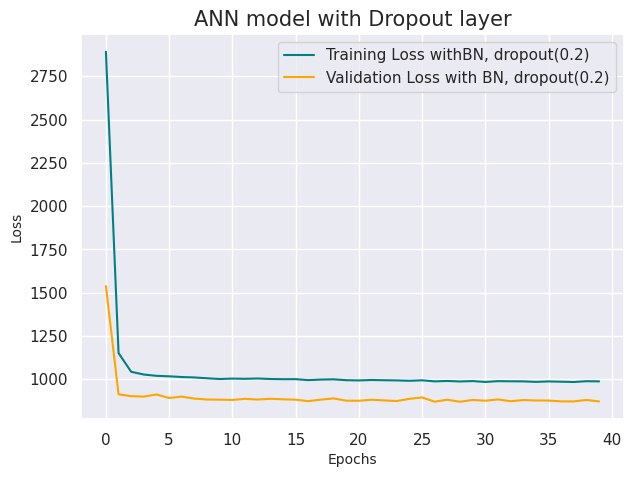

In [194]:
plt.figure(figsize = (7, 5))
plt.plot(history7.history['loss'], label = 'Training Loss withBN, dropout(0.2)', color = 'teal')
plt.plot(history7.history['val_loss'], label = 'Validation Loss with BN, dropout(0.2)', color = 'orange')
plt.title('ANN model with Dropout layer', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

In [200]:
X_test_f = ct.transform(X_test)

In [201]:
y_pred = model7.predict(X_test_f)

569/569 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [202]:
print('*** Test Mean Absolute Error is:', mean_absolute_error(y_test, y_pred))
print('*** Test Mean Squared Error is:', mean_squared_error(y_test, y_pred))
print('*** Test RMSE is:', np.sqrt(mean_squared_error(y_test, y_pred)))

*** Test Mean Absolute Error is: 866.4448838040444
*** Test Mean Squared Error is: 1744284.671451754
*** Test RMSE is: 1320.713697760326
